# SAM ONNX model evaluation (multi-weights + stats)

This notebook evaluates **multiple SAM ONNX checkpoints** on a test set, performs **paired statistical tests**, and plots **IoU vs number of clicks (1 / 3 / 5 points)**.

What you get:
- A **list of ONNX weights** (initializers) for each model + optional export to **`.npz` with the same basename**
- Per-sample metrics: **IoU, Precision, Recall, Dice (F1), Accuracy, Specificity**
- Paired stats:
  1) **Each tuned model vs the base model**
  2) **All pairwise comparisons between tuned models**
- Plot: **IoU vs clicks** for every model

> Notes  
> - “Clicks” are simulated by sampling points from a **seed mask**. If you only have GT masks, we use GT as a seed-region to sample clicks from (common for offline evaluation).  
> - For fair comparisons, we fix the random seed per-sample so all models see the **same sampled clicks**.


In [1]:
import os
import sys
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

from scipy import stats
import onnx
from onnx import numpy_helper


PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.inference_sam_onnx import SamModel

## 1) Configuration

Edit paths below:
- test images / masks (as `.npy`)
- SAM ONNX models (base + tuned)


In [2]:
# Test data (.npy)
TEST_IMAGES_DIR = r"..\data\raw\val\images"
TEST_MASKS_DIR  = r"..\data\raw\val\masks"

# SAM ONNX models (add as many tuned models as you want)
MODEL_PATHS = [
    r"..\data\SAM_vessels.onnx",                 # base (no pretrain)
    r"..\data\SAM_paleorusels_vessels.onnx",     # tuned
]

# Name of the base model (must match the basename of one of MODEL_PATHS)
BASE_MODEL_BASENAME = "SAM_vessels"

# Inference params
THRESHOLD = 0.5
DEVICE = "cpu"  # "cpu", "cuda", or "mps"

# Click counts to evaluate
N_POINTS_LIST =  [3] # [1, 3, 5]

# Reproducibility:
# we will set np.random.seed(SEED + sample_idx) before each inference call
SEED = 123

# Output folder for results (CSVs, weight dumps, etc.)
OUT_DIR = Path(PROJECT_ROOT) / "reports" / "sam_eval"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("TEST_IMAGES_DIR:", TEST_IMAGES_DIR)
print("TEST_MASKS_DIR :", TEST_MASKS_DIR)
print("OUT_DIR       :", OUT_DIR)
print("MODELS:")
for p in MODEL_PATHS:
    print(" -", Path(p).name)


PROJECT_ROOT: c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed
TEST_IMAGES_DIR: ..\data\raw\val\images
TEST_MASKS_DIR : ..\data\raw\val\masks
OUT_DIR       : c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed\reports\sam_eval
MODELS:
 - SAM_vessels.onnx
 - SAM_paleorusels_vessels.onnx


## 2) Load test data (`.npy`)

In [3]:
def load_npy_pairs(images_dir: str, masks_dir: str):
    """Load paired image/mask .npy files by filename intersection."""
    images_dir = Path(images_dir)
    masks_dir = Path(masks_dir)

    image_files = {p.name for p in images_dir.glob("*.npy")}
    mask_files  = {p.name for p in masks_dir.glob("*.npy")}
    common = sorted(list(image_files & mask_files))

    if not common:
        raise FileNotFoundError(
            f"No paired .npy files found.\nImages dir: {images_dir}\nMasks dir:  {masks_dir}"
        )

    images = []
    masks = []
    names = []

    for name in tqdm(common, desc="Loading .npy pairs"):
        img = np.load(images_dir / name)
        msk = np.load(masks_dir / name)

        # --- normalize shapes ---
        # image -> (H,W,3) uint8
        if img.ndim == 3 and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
        if img.dtype != np.uint8:
            # If your images are stored 0..1 float, convert to uint8
            if img.max() <= 1.0:
                img = (img * 255.0).clip(0,255).astype(np.uint8)
            else:
                img = img.clip(0,255).astype(np.uint8)

        # mask -> (H,W) uint8 {0,1}
        if msk.ndim == 3 and msk.shape[0] == 1:
            msk = msk.squeeze(0)
        if msk.ndim == 3 and msk.shape[-1] == 1:
            msk = msk.squeeze(-1)

        msk = (msk > 0).astype(np.uint8)

        images.append(img)
        masks.append(msk)
        names.append(name)

    return images, masks, names

images, gt_masks, sample_names = load_npy_pairs(TEST_IMAGES_DIR, TEST_MASKS_DIR)
print("Loaded samples:", len(images))
print("Example image shape:", images[0].shape, images[0].dtype)
print("Example mask shape :", gt_masks[0].shape, gt_masks[0].dtype, "unique:", np.unique(gt_masks[0]))


Loading .npy pairs: 100%|██████████| 5/5 [00:00<00:00, 286.00it/s]

Loaded samples: 5
Example image shape: (442, 1032, 3) uint8
Example mask shape : (442, 1032) uint8 unique: [0 1]


## 3) Metrics

In [4]:
def compute_metrics(pred: np.ndarray, gt: np.ndarray, eps: float = 1e-7) -> dict:
    """Compute segmentation metrics between binary masks pred and gt."""
    pred = (pred > 0).astype(np.uint8)
    gt   = (gt   > 0).astype(np.uint8)

    tp = np.sum((pred == 1) & (gt == 1))
    fp = np.sum((pred == 1) & (gt == 0))
    fn = np.sum((pred == 0) & (gt == 1))
    tn = np.sum((pred == 0) & (gt == 0))

    iou = tp / (tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    accuracy = (tp + tn) / (tp + tn + fp + fn + eps)
    specificity = tn / (tn + fp + eps)

    return {
        "IoU": float(iou),
        "Precision": float(precision),
        "Recall": float(recall),
        "Dice": float(dice),
        "Accuracy": float(accuracy),
        "Specificity": float(specificity),
    }


## 4) Export and list ONNX weights (initializers)

For each `*.onnx` in `MODEL_PATHS`, we:
- list initializers (name, dtype, shape, numel)
- export them to `*.npz` **with the same basename** next to results in `OUT_DIR/weights/`

> If you only want the list and not the `.npz` dump, set `DUMP_WEIGHTS = False`.


In [5]:
# Where to write the exported weights (*.npz with the same basename as *.onnx)
# - If True: weights go next to each .onnx as <model>.npz
# - If False: weights go into OUT_DIR/weights/<model>.npz
WRITE_WEIGHTS_NEXT_TO_ONNX = True
DUMP_WEIGHTS = True  # set False if you only want the list

WEIGHTS_DIR = (Path(MODEL_PATHS[0]).parent if WRITE_WEIGHTS_NEXT_TO_ONNX else (OUT_DIR / "weights"))
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)

WEIGHTS_LIST_DIR = OUT_DIR / "weights_lists"
WEIGHTS_LIST_DIR.mkdir(parents=True, exist_ok=True)

def list_and_dump_onnx_weights(onnx_path: str, dump: bool = True) -> pd.DataFrame:
    onnx_path = Path(onnx_path)
    model = onnx.load(str(onnx_path))

    rows = []
    weight_dict = {}

    for init in model.graph.initializer:
        arr = numpy_helper.to_array(init)
        rows.append({
            "name": init.name,
            "dtype": str(arr.dtype),
            "shape": tuple(arr.shape),
            "numel": int(arr.size),
        })
        if dump:
            weight_dict[init.name] = arr

    df = pd.DataFrame(rows).sort_values("numel", ascending=False).reset_index(drop=True)

    # Save weights list
    list_csv = WEIGHTS_LIST_DIR / f"{onnx_path.stem}_weights_list.csv"
    df.to_csv(list_csv, index=False)

    if dump:
        out_npz = (onnx_path.with_suffix(".npz") if WRITE_WEIGHTS_NEXT_TO_ONNX else (WEIGHTS_DIR / f"{onnx_path.stem}.npz"))
        np.savez_compressed(out_npz, **weight_dict)
        print(f"Saved weights to: {out_npz}")

    print(f"Saved weights list to: {list_csv}")
    return df

weights_tables = {}
for p in MODEL_PATHS:
    print("\n===", Path(p).name, "===")
    dfw = list_and_dump_onnx_weights(p, dump=DUMP_WEIGHTS)
    weights_tables[Path(p).stem] = dfw
    print("Initializers:", len(dfw), "| total params:", int(dfw['numel'].sum()))
    display(dfw.head(20))



=== SAM_vessels.onnx ===
Saved weights to: ..\data\SAM_vessels.npz
Saved weights list to: c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed\reports\sam_eval\weights_lists\SAM_vessels_weights_list.csv
Initializers: 297 | total params: 93597926


,name,dtype,shape,numel
0,sam_model.vision_encoder.pos_embed,float32,"(1, 64, 64, 768)",3145728
1,onnx::MatMul_7198,float32,"(3072, 768)",2359296
2,onnx::MatMul_7236,float32,"(768, 3072)",2359296
3,onnx::MatMul_6907,float32,"(3072, 768)",2359296
4,onnx::MatMul_6906,float32,"(768, 3072)",2359296
5,onnx::MatMul_6868,float32,"(3072, 768)",2359296
6,onnx::MatMul_6867,float32,"(768, 3072)",2359296
7,onnx::MatMul_6805,float32,"(3072, 768)",2359296
8,onnx::MatMul_6804,float32,"(768, 3072)",2359296
9,onnx::MatMul_7299,float32,"(768, 3072)",2359296



=== SAM_paleorusels_vessels.onnx ===
Saved weights to: ..\data\SAM_paleorusels_vessels.npz
Saved weights list to: c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed\reports\sam_eval\weights_lists\SAM_paleorusels_vessels_weights_list.csv
Initializers: 297 | total params: 93597926


,name,dtype,shape,numel
0,sam_model.vision_encoder.pos_embed,float32,"(1, 64, 64, 768)",3145728
1,onnx::MatMul_7198,float32,"(3072, 768)",2359296
2,onnx::MatMul_7236,float32,"(768, 3072)",2359296
3,onnx::MatMul_6907,float32,"(3072, 768)",2359296
4,onnx::MatMul_6906,float32,"(768, 3072)",2359296
5,onnx::MatMul_6868,float32,"(3072, 768)",2359296
6,onnx::MatMul_6867,float32,"(768, 3072)",2359296
7,onnx::MatMul_6805,float32,"(3072, 768)",2359296
8,onnx::MatMul_6804,float32,"(768, 3072)",2359296
9,onnx::MatMul_7299,float32,"(768, 3072)",2359296


## 5) Evaluate all SAM models for click counts (1 / 3 / 5)

In [6]:
METRICS = ["IoU", "Dice", "Precision", "Recall", "Accuracy", "Specificity"]

def evaluate_one_model(
    model_path: str,
    images: list,
    gt_masks: list,
    sample_names: list,
    n_points: int,
    threshold: float,
    device: str,
    seed: int = 0
) -> pd.DataFrame:
    """Evaluate one SAM ONNX model for a given n_points."""
    model = SamModel(
        model_path=str(model_path),
        device=device,
        n_points=int(n_points),
        thresh=float(threshold)
    )

    rows = []
    for i, (img, gt, name) in enumerate(tqdm(zip(images, gt_masks, sample_names), total=len(images),
                                            desc=f"{Path(model_path).stem} | n_points={n_points}")):
        # Make click sampling deterministic per-sample
        np.random.seed(seed + i)

        # Use GT mask as seed-region (offline click simulation)
        pred, _ = model.infer(img, gt, return_probs=False)
        m = compute_metrics(pred, gt)
        m.update({
            "sample": name,
            "model": Path(model_path).stem,
            "n_points": int(n_points),
        })
        rows.append(m)

    return pd.DataFrame(rows)

all_results = []
for model_path in MODEL_PATHS:
    for n_points in N_POINTS_LIST:
        df = evaluate_one_model(
            model_path=model_path,
            images=images,
            gt_masks=gt_masks,
            sample_names=sample_names,
            n_points=n_points,
            threshold=THRESHOLD,
            device=DEVICE,
            seed=SEED
        )
        all_results.append(df)

results = pd.concat(all_results, ignore_index=True)

# Save per-sample results
per_sample_csv = OUT_DIR / "per_sample_metrics.csv"
results.to_csv(per_sample_csv, index=False)
print("Saved per-sample metrics:", per_sample_csv)

results.head()


SAM_vessels | n_points=3: 100%|██████████| 5/5 [00:24<00:00,  4.92s/it]
SAM_paleorusels_vessels | n_points=3: 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]


Saved per-sample metrics: c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed\reports\sam_eval\per_sample_metrics.csv


,IoU,Precision,Recall,Dice,Accuracy,Specificity,sample,model,n_points
0,0.000000,0.000000,0.000000,0.000000,0.911344,1.000000,2.npy,SAM_vessels,3
1,0.009857,0.033617,0.013755,0.019522,0.967380,0.990439,3.npy,SAM_vessels,3
2,0.114644,0.341862,0.147114,0.205706,0.815380,0.945046,31.npy,SAM_vessels,3
3,0.064608,0.123690,0.119144,0.121374,0.768531,0.869177,32.npy,SAM_vessels,3
4,0.049718,0.112347,0.081882,0.094726,0.797480,0.903841,33.npy,SAM_vessels,3


### Summary (mean ± std over samples)

In [7]:
summary = (
    results
    .groupby(["model", "n_points"])[METRICS]
    .agg(["mean", "std"])
)

# Flatten columns
summary.columns = [f"{m}_{stat}" for m, stat in summary.columns]
summary = summary.reset_index()

summary_csv = OUT_DIR / "summary_mean_std.csv"
summary.to_csv(summary_csv, index=False)
print("Saved summary:", summary_csv)

summary.sort_values(["n_points", "model"]).head(20)


Saved summary: c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed\reports\sam_eval\summary_mean_std.csv


,model,n_points,IoU_mean,IoU_std,Dice_mean,Dice_std,Precision_mean,Precision_std,Recall_mean,Recall_std,Accuracy_mean,Accuracy_std,Specificity_mean,Specificity_std
0,SAM_paleorusels_vessels,3,0.049049,0.044451,0.090793,0.080207,0.140052,0.143986,0.070044,0.059942,0.861504,0.074793,0.953318,0.045642
1,SAM_vessels,3,0.047765,0.046040,0.088266,0.082835,0.122303,0.133351,0.072379,0.064300,0.852023,0.083837,0.941701,0.055854


## 6) Paired statistical tests

We run **paired tests** on per-sample metrics:

1. **Each tuned model vs base** (BASE_MODEL_BASENAME)
2. **Pairwise between tuned models**

Default test: **Wilcoxon signed-rank** (non-parametric, paired).  
We also report: mean difference (A-B) and paired Cohen's d on differences.

Multiple-comparison correction per `(n_points, metric)` block: **Holm**.


In [8]:
def _paired_effects(x: np.ndarray, y: np.ndarray):
    diff = x - y
    mean_diff = float(np.mean(diff))
    sd = float(np.std(diff, ddof=1)) if diff.size > 1 else 0.0
    cohen_d = float(mean_diff / (sd + 1e-12))
    return mean_diff, cohen_d

def paired_wilcoxon(x: np.ndarray, y: np.ndarray):
    # Handle edge case: all equal
    if np.allclose(x, y):
        return 0.0, 1.0
    try:
        stat, p = stats.wilcoxon(x, y, zero_method="wilcox", alternative="two-sided")
        return float(stat), float(p)
    except ValueError:
        # e.g., not enough non-zero differences
        return 0.0, 1.0

def holm_correction(pvals: np.ndarray):
    """Return Holm-adjusted p-values in the original order."""
    pvals = np.asarray(pvals, dtype=float)
    m = pvals.size
    order = np.argsort(pvals)
    adj = np.empty_like(pvals)
    for k, idx in enumerate(order):
        adj[idx] = min(1.0, (m - k) * pvals[idx])
    # enforce monotonicity in sorted order
    sorted_adj = adj[order]
    for i in range(1, m):
        sorted_adj[i] = max(sorted_adj[i], sorted_adj[i-1])
    adj[order] = sorted_adj
    return adj

def build_pairwise_stats(results_df: pd.DataFrame, model_a: str, model_b: str, n_points: int) -> pd.DataFrame:
    """Paired stats for model_a vs model_b at fixed n_points."""
    a = results_df[(results_df["model"] == model_a) & (results_df["n_points"] == n_points)].sort_values("sample")
    b = results_df[(results_df["model"] == model_b) & (results_df["n_points"] == n_points)].sort_values("sample")

    # Ensure identical sample order
    if not a["sample"].tolist() == b["sample"].tolist():
        raise RuntimeError("Sample mismatch between models. Ensure same test set.")

    rows = []
    for metric in METRICS:
        x = a[metric].to_numpy()
        y = b[metric].to_numpy()
        w_stat, p = paired_wilcoxon(x, y)
        mean_diff, cohen_d = _paired_effects(x, y)
        rows.append({
            "n_points": int(n_points),
            "metric": metric,
            "model_A": model_a,
            "model_B": model_b,
            "wilcoxon_stat": w_stat,
            "p_value": p,
            "mean_diff_A_minus_B": mean_diff,
            "cohen_d_paired": cohen_d,
        })
    return pd.DataFrame(rows)

# Identify base / tuned models
all_model_names = [Path(p).stem for p in MODEL_PATHS]
if BASE_MODEL_BASENAME not in all_model_names:
    raise ValueError(f"BASE_MODEL_BASENAME='{BASE_MODEL_BASENAME}' not found among models: {all_model_names}")

tuned_models = [m for m in all_model_names if m != BASE_MODEL_BASENAME]
print("Base model :", BASE_MODEL_BASENAME)
print("Tuned models:", tuned_models)

# 6.1 Base vs each tuned
base_vs_tuned = []
for n_points in N_POINTS_LIST:
    for tuned in tuned_models:
        base_vs_tuned.append(build_pairwise_stats(results, tuned, BASE_MODEL_BASENAME, n_points))

base_vs_tuned_df = pd.concat(base_vs_tuned, ignore_index=True)

# Holm correction within each (n_points, metric) across comparisons
base_vs_tuned_df["p_holm"] = np.nan
for n_points in N_POINTS_LIST:
    for metric in METRICS:
        mask = (base_vs_tuned_df["n_points"] == n_points) & (base_vs_tuned_df["metric"] == metric)
        pvals = base_vs_tuned_df.loc[mask, "p_value"].to_numpy()
        base_vs_tuned_df.loc[mask, "p_holm"] = holm_correction(pvals)

base_vs_tuned_csv = OUT_DIR / "stats_base_vs_tuned_wilcoxon_holm.csv"
base_vs_tuned_df.to_csv(base_vs_tuned_csv, index=False)
print("Saved base-vs-tuned stats:", base_vs_tuned_csv)

base_vs_tuned_df.sort_values(["n_points", "metric", "p_holm"]).head(30)


Base model : SAM_vessels
Tuned models: ['SAM_paleorusels_vessels']
Saved base-vs-tuned stats: c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed\reports\sam_eval\stats_base_vs_tuned_wilcoxon_holm.csv


,n_points,metric,model_A,model_B,wilcoxon_stat,p_value,mean_diff_A_minus_B,cohen_d_paired,p_holm
4,3,Accuracy,SAM_paleorusels_vessels,SAM_vessels,1.0,0.250,0.009481,0.756148,0.250
1,3,Dice,SAM_paleorusels_vessels,SAM_vessels,2.0,0.375,0.002528,0.448305,0.375
0,3,IoU,SAM_paleorusels_vessels,SAM_vessels,2.0,0.375,0.001283,0.397875,0.375
2,3,Precision,SAM_paleorusels_vessels,SAM_vessels,0.0,0.125,0.017749,1.146757,0.125
3,3,Recall,SAM_paleorusels_vessels,SAM_vessels,3.0,0.625,-0.002335,-0.326296,0.625
5,3,Specificity,SAM_paleorusels_vessels,SAM_vessels,1.0,0.250,0.011617,0.784569,0.250


### 6.2 Pairwise stats between tuned models

In [9]:
tuned_pairwise = []
for n_points in N_POINTS_LIST:
    for a, b in itertools.combinations(tuned_models, 2):
        tuned_pairwise.append(build_pairwise_stats(results, a, b, n_points))

if tuned_pairwise:
    tuned_pairwise_df = pd.concat(tuned_pairwise, ignore_index=True)

    tuned_pairwise_df["p_holm"] = np.nan
    for n_points in N_POINTS_LIST:
        for metric in METRICS:
            mask = (tuned_pairwise_df["n_points"] == n_points) & (tuned_pairwise_df["metric"] == metric)
            pvals = tuned_pairwise_df.loc[mask, "p_value"].to_numpy()
            tuned_pairwise_df.loc[mask, "p_holm"] = holm_correction(pvals)

    tuned_pairwise_csv = OUT_DIR / "stats_tuned_pairwise_wilcoxon_holm.csv"
    tuned_pairwise_df.to_csv(tuned_pairwise_csv, index=False)
    print("Saved tuned pairwise stats:", tuned_pairwise_csv)

    tuned_pairwise_df.sort_values(["n_points", "metric", "p_holm"]).head(30)
else:
    print("No tuned-tuned comparisons (only one tuned model).")


No tuned-tuned comparisons (only one tuned model).


## 7) Plot: IoU vs number of clicks (1 / 3 / 5)

,model,n_points,mean,std,count
0,SAM_paleorusels_vessels,3,0.049049,0.044451,5
1,SAM_vessels,3,0.047765,0.046040,5


Saved plot: c:\Users\marga\Documents\NSUUU\IT-Geo-Paleoriverbed\reports\sam_eval\iou_vs_clicks.png


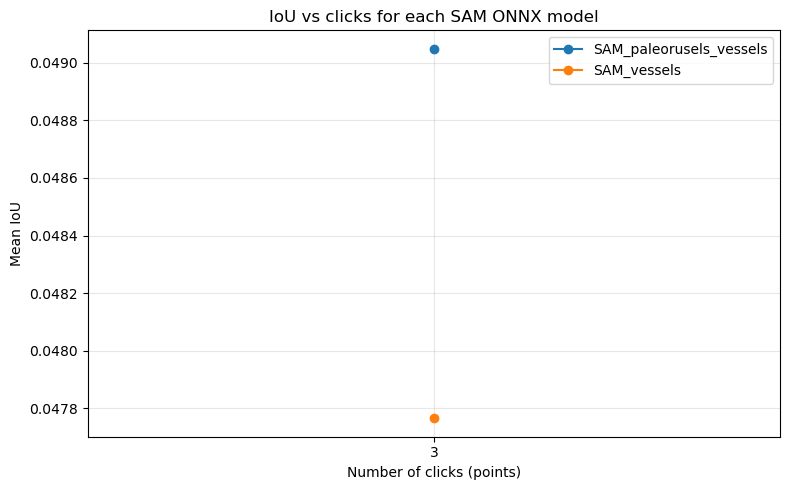

In [10]:
# Compute mean IoU per (model, n_points)
iou_curve = (
    results.groupby(["model", "n_points"])["IoU"]
    .agg(["mean", "std", "count"])
    .reset_index()
    .sort_values(["model", "n_points"])
)

display(iou_curve)

plt.figure(figsize=(8, 5))
for model_name, g in iou_curve.groupby("model"):
    g = g.sort_values("n_points")
    plt.plot(g["n_points"], g["mean"], marker="o", label=model_name)
    # Optional error bars:
    # plt.fill_between(g["n_points"], g["mean"]-g["std"], g["mean"]+g["std"], alpha=0.2)

plt.xticks(N_POINTS_LIST)
plt.xlabel("Number of clicks (points)")
plt.ylabel("Mean IoU")
plt.title("IoU vs clicks for each SAM ONNX model")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

plot_path = OUT_DIR / "iou_vs_clicks.png"
plt.savefig(plot_path, dpi=200)
print("Saved plot:", plot_path)
plt.show()


## 8) Where outputs are saved

### Metrics + stats
- `reports/sam_eval/per_sample_metrics.csv`
- `reports/sam_eval/summary_mean_std.csv`
- `reports/sam_eval/stats_base_vs_tuned_wilcoxon_holm.csv`
- `reports/sam_eval/stats_tuned_pairwise_wilcoxon_holm.csv` (if >=2 tuned models)
- `reports/sam_eval/iou_vs_clicks.png`

### ONNX weight exports
- Weights list (CSV): `reports/sam_eval/weights_lists/<model>_weights_list.csv`
- Weights dump (NPZ):  
  - If `WRITE_WEIGHTS_NEXT_TO_ONNX=True`: next to each ONNX as `<model>.npz`  
  - Else: `reports/sam_eval/weights/<model>.npz`
